In [42]:
import os
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
DATA_DIR = '../input/abstract-art-gallery'
print(os.listdir(DATA_DIR))

['Abstract_gallery_2', 'Abstract_gallery']


In [44]:
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_gallery']


In [45]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [46]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [47]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [48]:
def show_images(images,nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_xticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

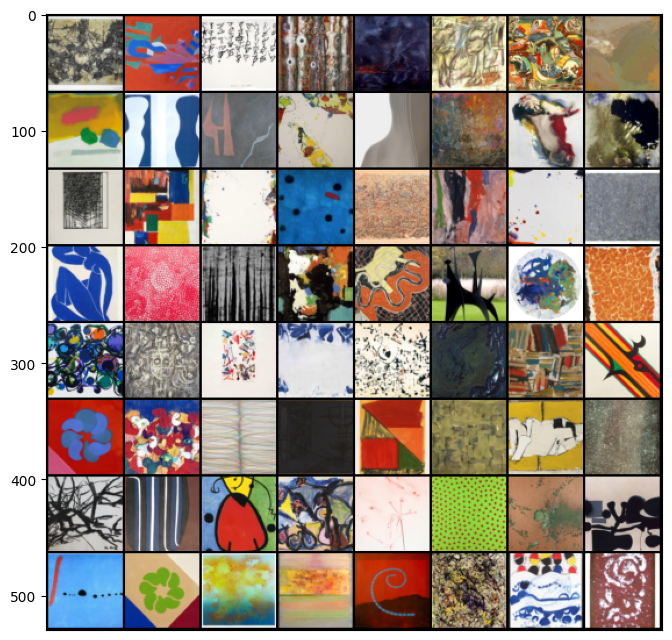

In [49]:
show_batch(train_dl)

In [50]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [51]:
device = get_default_device()
device

device(type='cpu')

In [52]:
train_dl = DeviceDataLoader(train_dl, device)

In [53]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [54]:
discriminator = to_device(discriminator, device)
latent_size = 128

In [55]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


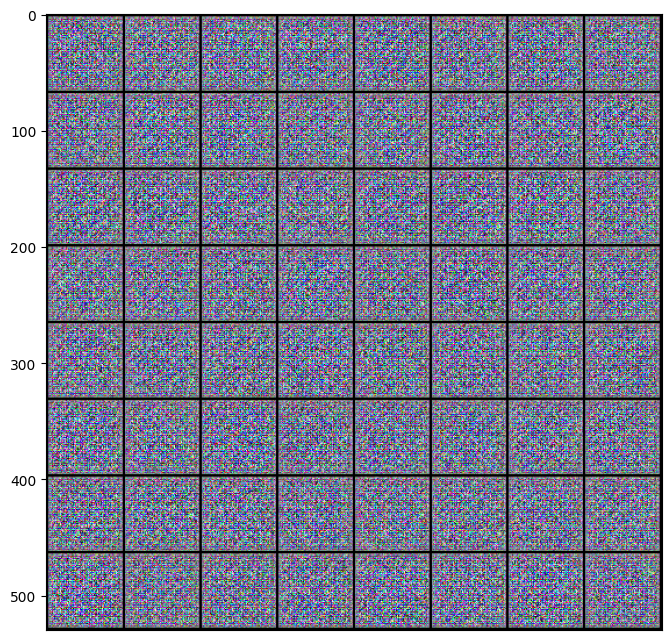

In [56]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [57]:
generator = to_device(generator, device)

In [58]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [59]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [60]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [61]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [62]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [63]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [67]:
lr = 0.0002
epochs = 20

In [68]:
history = fit(epochs, lr)

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 3.4293, loss_d: 0.2033, real_score: 0.9573, fake_score: 0.1320
Saving generated-images-0001.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 2.1620, loss_d: 0.6271, real_score: 0.6717, fake_score: 0.1573
Saving generated-images-0002.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 2.2226, loss_d: 0.6982, real_score: 0.6941, fake_score: 0.2538
Saving generated-images-0003.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 5.7664, loss_d: 0.5092, real_score: 0.9446, fake_score: 0.3383
Saving generated-images-0004.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 3.2292, loss_d: 0.9244, real_score: 0.4529, fake_score: 0.0183
Saving generated-images-0005.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 5.4848, loss_d: 0.6539, real_score: 0.5700, fake_score: 0.0126
Saving generated-images-0006.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 7.4231, loss_d: 0.9559, real_score: 0.8070, fake_score: 0.4531
Saving generated-images-0007.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 5.5364, loss_d: 0.4787, real_score: 0.8137, fake_score: 0.2071
Saving generated-images-0008.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 4.8322, loss_d: 0.6513, real_score: 0.9307, fake_score: 0.3913
Saving generated-images-0009.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 4.7097, loss_d: 0.4703, real_score: 0.7222, fake_score: 0.0283
Saving generated-images-0010.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 4.2570, loss_d: 0.7558, real_score: 0.9175, fake_score: 0.4665
Saving generated-images-0011.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 2.7828, loss_d: 0.4056, real_score: 0.8934, fake_score: 0.2230
Saving generated-images-0013.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 2.8073, loss_d: 0.3451, real_score: 0.8429, fake_score: 0.1441
Saving generated-images-0014.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 3.7259, loss_d: 0.5870, real_score: 0.8751, fake_score: 0.3320
Saving generated-images-0015.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 5.0379, loss_d: 0.4744, real_score: 0.9472, fake_score: 0.3154
Saving generated-images-0016.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 2.1206, loss_d: 0.7901, real_score: 0.5687, fake_score: 0.1134
Saving generated-images-0017.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 3.7129, loss_d: 0.4869, real_score: 0.7537, fake_score: 0.1124
Saving generated-images-0018.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 3.9688, loss_d: 0.3743, real_score: 0.8521, fake_score: 0.1561
Saving generated-images-0019.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 4.6275, loss_d: 0.7293, real_score: 0.7828, fake_score: 0.3378
Saving generated-images-0020.png


In [70]:
losses_g, losses_d, real_scores, fake_scores = history

In [71]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

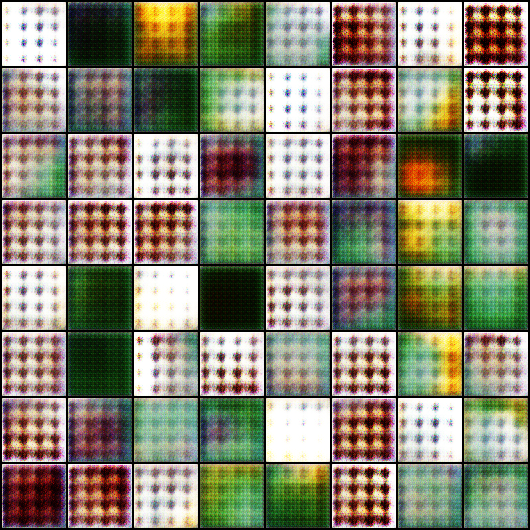

In [76]:
Image('./generated/generated-images-0015.png')

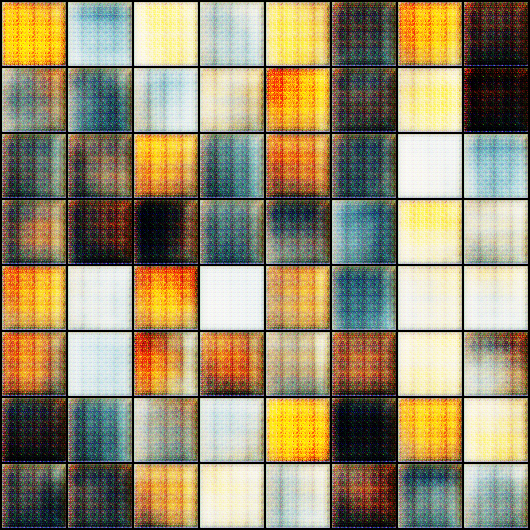

In [77]:
Image('./generated/generated-images-0009.png')

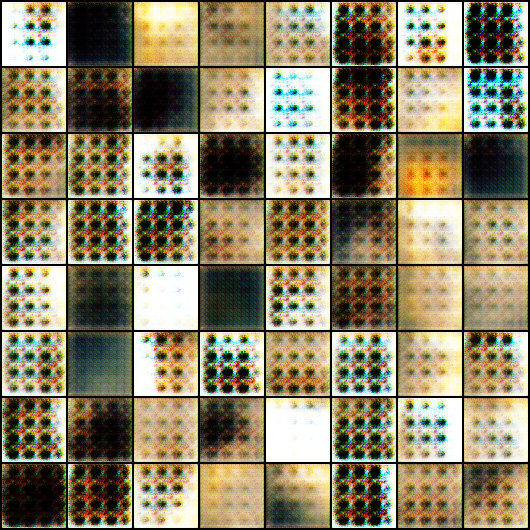

In [78]:
Image('./generated/generated-images-0016.png')

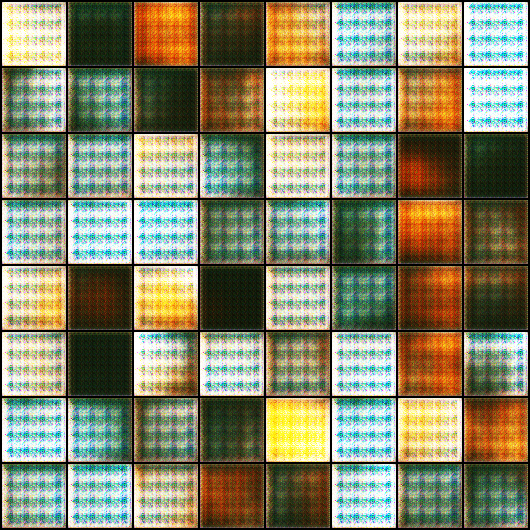

In [79]:
Image('./generated/generated-images-0011.png')

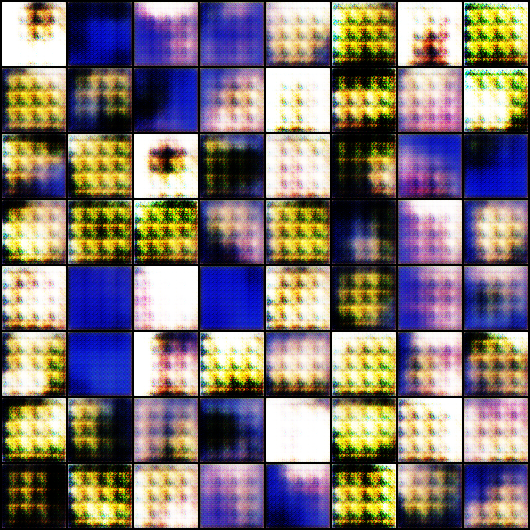

In [80]:
Image('./generated/generated-images-0018.png')

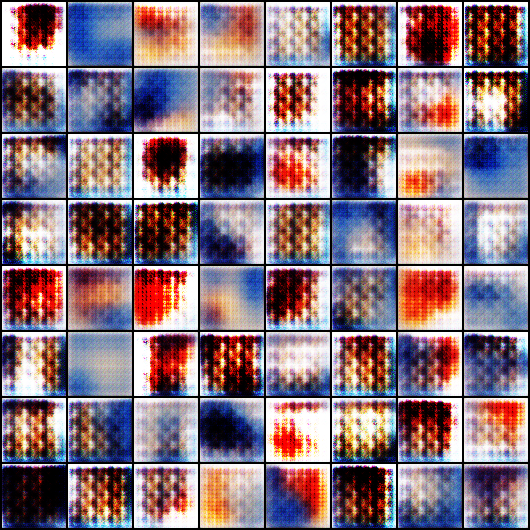

In [81]:
Image('./generated/generated-images-0020.png')

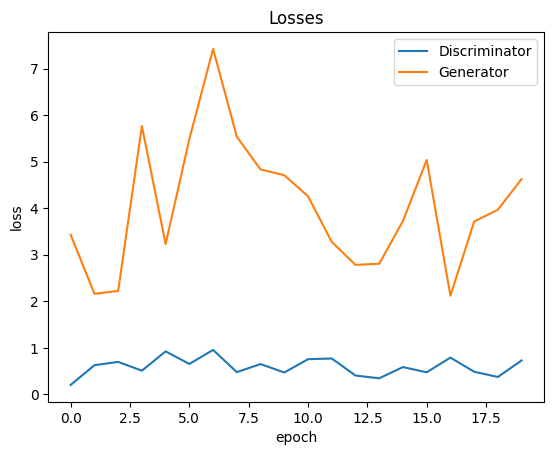

In [82]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

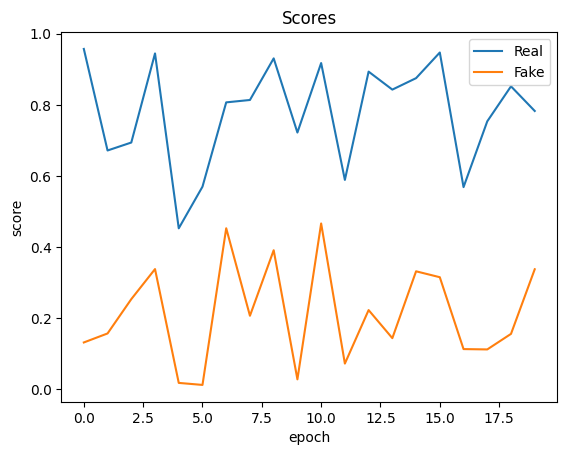

In [83]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');